# Project 1 - Genomic Alignment
Shea Conaway (shea.conaway@vanderbilt.edu)

## Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read reads.fq
names = []
reads = []
with open('data/reads.fq') as f:
    for i, line in enumerate(f):
        if i % 4 == 0:
            names.append(line)
        if (i-1) % 4 == 0:
            reads.append(line)

# create dataframe
reads = pd.DataFrame({'name': names, 'read': reads})
print(reads.shape)

(2000, 2)


In [3]:
# read reference genome file
reference = pd.read_csv('data/reference_chr21_20000000_20050000.fa')
print(reference.shape)

(500, 3)


## Milestone 1: 80%
- Correct data preprocess (cut sequence into k-mers, one-hot encoding)
- Correct minhash function / any other hash function that applies
- Calculate jaccard similarity and report the alignment result

### Step 1
Cut reads into kmers

In [4]:
# cut each read into 15-mers lagged by one base
reads['kmers'] = reads['read'].apply(lambda x: [x[i:i+15] for i in range(0, len(x)-15, 1)])

In [5]:
reads.head()

,name,read,kmers
0,@ST-K00126:336:H5W53BBXX:19962722:20120330:505...,TCCTTACTGGTTTTGCAGGTAACTTATAGAGTATTTCCACTTCCCT...,"[TCCTTACTGGTTTTG, CCTTACTGGTTTTGC, CTTACTGGTTT..."
1,@ST-K00126:1714:H5W53BBXX:19876023:20073038:13...,GGTTTTTCAGGTAACTTATAGAGTATTTCCACTTCCCTTCTCCTAT...,"[GGTTTTTCAGGTAAC, GTTTTTCAGGTAACT, TTTTTCAGGTA..."
2,@ST-K00126:128:H5W53BBXX:19846943:20117449:173...,AGGTAACTTATAGAGTACTTCCACTTCCCTTCTCCTATCCCTTGAA...,"[AGGTAACTTATAGAG, GGTAACTTATAGAGT, GTAACTTATAG..."
3,@ST-K00126:123:H5W53BBXX:19995295:20041917:180...,CACTTCCCTTCTACTATCCCTTGAAAAATTGTCATTTATTTCTCTT...,"[CACTTCCCTTCTACT, ACTTCCCTTCTACTA, CTTCCCTTCTA..."
4,@ST-K00126:445:H5W53BBXX:19998589:20051598:219...,CCTTCTCCTATCCCTTGAAAAATTGTCATTTATTTCCCTTATCCAT...,"[CCTTCTCCTATCCCT, CTTCTCCTATCCCTT, TTCTCCTATCC..."


### Step 2
Cut reference bins into kmers

In [6]:
# cut each reference into 15-mers lagged by one base
reference['kmers'] = reference['sequence'].apply(lambda x: [x[i:i+15] for i in range(0, len(x)-15, 1)])

In [7]:
reference.head()

,start,end,sequence,kmers
0,20000000,20000100,CCCTTCTCCTATCCCTTGAAAAATTGTCATTTATTTCTCTTATCCA...,"[CCCTTCTCCTATCCC, CCTTCTCCTATCCCT, CTTCTCCTATC..."
1,20000100,20000200,TAGATTCATTTAGAATATAAAAAAATTTTATTTTATTTTCACTTAT...,"[TAGATTCATTTAGAA, AGATTCATTTAGAAT, GATTCATTTAG..."
2,20000200,20000300,TTCTTCTTCCTGAAGAAAATATTTTAACATTTCCTGCATGGGTGGT...,"[TTCTTCTTCCTGAAG, TCTTCTTCCTGAAGA, CTTCTTCCTGA..."
3,20000300,20000400,ACTTTTCAAGGATAGTTTTGTGGGATACAGAATTCTAGATCAGCGT...,"[ACTTTTCAAGGATAG, CTTTTCAAGGATAGT, TTTTCAAGGAT..."
4,20000400,20000500,CTGACAGGACTTCTGCCAAGGACAACTTTCCTGTAATGTTTATCTT...,"[CTGACAGGACTTCTG, TGACAGGACTTCTGC, GACAGGACTTC..."


### Step 3
Collect all kmers (from reads and reference bins) and build a distinct kmer set

In [8]:
# collect distinct kmers from reads and reference
kmers_set = set()
for kmers_list in reads['kmers']:
    kmers_set.update(kmers_list)
for kmers_list in reference['kmers']:
    kmers_set.update(kmers_list)

In [9]:
# print number of distinct kmers
print(len(kmers_set))

72445


### Steps 4 and 5
Use kmer to encode reads and reference using one-hot encoding

In [10]:
def kmer_encode(kmers_set,df):

    # create empty dict
    kmers_encoding = {}

    # one-hot encode kmers for each read
    for kmer in kmers_set:
        kmers_encoding[kmer] = df['kmers'].apply(lambda x: 1 if kmer in x else 0)

    # convert dict to df and append to reads
    kmers_encoding = pd.DataFrame(kmers_encoding)
    df = pd.concat([df, kmers_encoding], axis=1)

    return df

In [11]:
# encode reads
reads_enc = kmer_encode(kmers_set,reads)
print(reads_enc.shape)

(2000, 72448)


In [12]:
# encode reference
reference_enc = kmer_encode(kmers_set,reference)
print(reference_enc.shape)

(500, 72449)


In [13]:
# drop unneeded columns
reads_enc.drop(['name', 'read', 'kmers'], axis=1, inplace=True)
reference_enc.drop(['start', 'end', 'sequence', 'kmers'], axis=1, inplace=True)

In [14]:
reads_enc.head()

,CAACAGATCTGCTTA,ACCATCTAATTTATT,TCTCTGTGTCTTTCT,ACATACAGAAATCGT,TTTCAAGAACTACAG,TTAAGCATTATATGT,TCCATATTACATACA,AAGAGCAGGCCTCTG,CACAATTTTTTGTAA,AAGATACATTTTAAA,...,CTTCAAAAAAATTTT,CAATATTCAACTTTG,TAGGCCATACTATAC,TGAAAATAGCCAATT,TTATATCTACCATCA,AAGATGCCTCTCTGA,CACGTACAATTAACT,TAATCTGTGTTTGTC,GGCAATCTATTGTCT,TTTAGTGTATGATCT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
reference_enc.head()

,CAACAGATCTGCTTA,ACCATCTAATTTATT,TCTCTGTGTCTTTCT,ACATACAGAAATCGT,TTTCAAGAACTACAG,TTAAGCATTATATGT,TCCATATTACATACA,AAGAGCAGGCCTCTG,CACAATTTTTTGTAA,AAGATACATTTTAAA,...,CTTCAAAAAAATTTT,CAATATTCAACTTTG,TAGGCCATACTATAC,TGAAAATAGCCAATT,TTATATCTACCATCA,AAGATGCCTCTCTGA,CACGTACAATTAACT,TAATCTGTGTTTGTC,GGCAATCTATTGTCT,TTTAGTGTATGATCT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 6
Use minhash to reduce the feature dimension for reads and reference bins

In [16]:
def minhash_signature(row, num_hashes):
    # Initialize an array of hash values with infinity
    hash_vals = np.full(num_hashes, np.inf)

    # run multiple hash functions on each present kmer, store  global minimum value for each hash function
    for kmer in row.index[row == 1]: # loop over kmers that are present in the read
        for i in range(num_hashes): # loop of hash functions
            # hash the kmer with the hash function
            # appending the hash function number to make it unique
            hash_val = hash(kmer + str(i))
            hash_vals[i] = min(hash_vals[i], hash_val)

    return hash_vals


#### Hash Function Explainer

The code appends `str(i)` to the `kmer` string to make the resulting hash value unique for each hash function `i`. The purpose of this is to ensure that each hash function produces a unique hash value for each kmer.

In this implementation of minhash signature, multiple hash functions are used to generate the minhash signature for each row (which represents a sequence of k-mers). To ensure that the hash values generated by each hash function are independent and do not collide with each other, the hash function is applied to the concatenation of the kmer string with the string representation of the hash function number i.

By appending str(i) to kmer, we are effectively creating a unique hash value for each combination of kmer and i. This ensures that the hash values produced by each hash function are distinct and do not overlap. If we did not include str(i) in the input to the hash function, the same kmer string could potentially generate the same hash value for multiple hash functions, which would defeat the purpose of using multiple hash functions to generate a minhash signature.

Each element of the minhash signature across k-mers does not need to be produced with the same hash function. In fact, the key idea behind minhashing is to use multiple hash functions to generate a signature for each set of k-mers, where each element of the signature is produced by a different hash function.

The basic idea of minhashing is to use a set of hash functions to map each k-mer in a set to a different bucket or bin, and then to identify the smallest hash value in each bin. The resulting set of smallest hash values forms the minhash signature for that set of k-mers.

By using multiple hash functions to generate the minhash signature, we can obtain a more robust estimate of the Jaccard similarity between sets of k-mers, even if some hash functions happen to produce poor estimates for some k-mers.

Therefore, to obtain an accurate minhash signature, it is important to use a set of hash functions that are well-suited to the specific application and that can generate independent hash values for each k-mer in the set. However, each element of the minhash signature can be produced by a different hash function, and this is a key aspect of the minhashing algorithm.

In [17]:
# number of hashes/functions
num_hashes = 1000

# Compute MinHash signatures for reads and reference sequences
reads_sigs = reads_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)
refs_sigs = reference_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)

In [18]:
# review slice of sample signature
reads_sigs[0][0:10]

array([-9.03391780e+18, -9.09894239e+18, -8.81742205e+18, -9.08206077e+18,
       -8.86867978e+18, -9.01286504e+18, -8.97099142e+18, -9.17110146e+18,
       -9.21230517e+18, -9.17434650e+18])

### Step 7
Calculate the jaccard similarity between reads and bins and find the most similar bin for every read

In [19]:
# Jaccard similarity function for two signatures
def jaccard_similarity(sig1, sig2):
    intersection = np.sum(sig1 == sig2)
    union = len(np.union1d(sig1, sig2))
    if union == 0:
        return 0
    else:
        return intersection / union

In [20]:
# for each read signature, find the reference signature with the highest Jaccard similarity

results = []
for read_index, read_sig in reads_sigs.items():
    max_similarity = 0
    max_ref_index = np.random.randint(0, len(refs_sigs)) # random init instead of NaN
    for ref_index, ref_sig in refs_sigs.items():
        similarity = jaccard_similarity(read_sig, ref_sig)
        if similarity > max_similarity:
            max_similarity = similarity
            max_ref_index = ref_index
    results.append((read_index, max_ref_index, max_similarity))
results_df = pd.DataFrame(results, columns=['read_index', 'max_ref_index', 'max_similarity'])

# results
results_df.head()


,read_index,max_ref_index,max_similarity
0,0,0,0.220256
1,1,0,0.176471
2,2,0,0.229256
3,3,0,0.560062
4,4,0,0.498127


In [21]:
# join results with reference on ref_index to get start column only
results_df = results_df.join(reference['start'], on='max_ref_index')
results_df.rename(columns={'start': 'ref_start'}, inplace=True)
results_df

,read_index,max_ref_index,max_similarity,ref_start
0,0,0,0.220256,20000000
1,1,0,0.176471,20000000
2,2,0,0.229256,20000000
3,3,0,0.560062,20000000
4,4,0,0.498127,20000000
...,...,...,...,...
1995,1995,434,0.194743,20043400
1996,1996,434,0.116695,20043400
1997,1997,435,0.124227,20043500
1998,1998,435,0.199760,20043500


## Milestone 2: 20%
- Apply parallel in hash function; show the time cost before and after parallel
- Report the pearson correlation and MSE of your result compared to benchmark; the pearson correlation should be >0.8, and MSE should be <2500.

### Step 8
Compare your alignment result with the benchmark
( read_position_benchmark.csv). Does your result conform with the benchmark?
- You can show the pearson correlation between your result and the benchmark
- You can draw a scatter plot to show the correlation
- You can also calculate the mean square error

In [22]:
benchmark = pd.read_csv('data/read_position_benchmark.csv', index_col=0)

In [23]:
benchmark.head()

,readname,reference_start,reference_end
0,ST-K00126:336:H5W53BBXX:19962722:20120330:5053...,19999958,20000058
1,ST-K00126:1714:H5W53BBXX:19876023:20073038:137...,19999966,20000066
2,ST-K00126:128:H5W53BBXX:19846943:20117449:1735...,19999974,20000074
3,ST-K00126:123:H5W53BBXX:19995295:20041917:1801...,19999995,20000095
4,ST-K00126:445:H5W53BBXX:19998589:20051598:2192...,20000001,20000101


In [24]:
# join results with benchmark=
results_df = results_df.join(benchmark['reference_start'], on='read_index')
results_df.rename(columns={'reference_start': 'benchmark_start'}, inplace=True)
results_df.head()

,read_index,max_ref_index,max_similarity,ref_start,benchmark_start
0,0,0,0.220256,20000000,19999958
1,1,0,0.176471,20000000,19999966
2,2,0,0.229256,20000000,19999974
3,3,0,0.560062,20000000,19999995
4,4,0,0.498127,20000000,20000001


In [25]:
# compute correlation between benchmark and reference start
results_df['ref_start'].corr(results_df['benchmark_start'])

0.9999971186503247

In [26]:
# print top 5 differences between ref_start and benchmark_start
results_df['diff'] = results_df['ref_start'] - results_df['benchmark_start']
results_df.sort_values('diff', ascending=False).head()


,read_index,max_ref_index,max_similarity,ref_start,benchmark_start,diff
1985,1985,432,0.100110,20043200,20043139,61
421,421,103,0.098901,20010300,20010239,61
262,262,70,0.098298,20007000,20006940,60
614,614,145,0.100715,20014500,20014440,60
7,7,1,0.112347,20000100,20000040,60


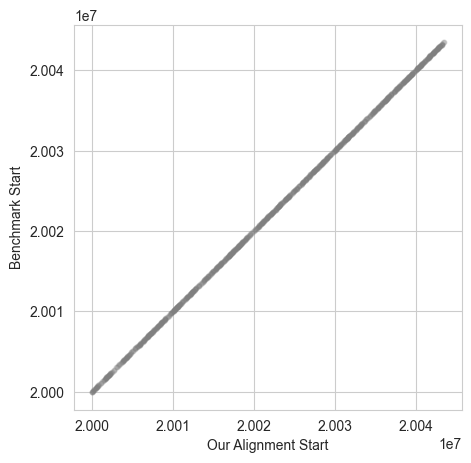

In [27]:
# scatterplot of benchmark and reference start
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
plt.scatter(results_df['ref_start'], results_df['benchmark_start'], alpha=0.1, s=10, color="gray")
plt.xlabel('Our Alignment Start')
plt.ylabel('Benchmark Start')
plt.show()

In [28]:
# calculate the mse between benchmark and reference start
np.mean((results_df['ref_start'] - results_df['benchmark_start'])**2)

894.8645

### Step 9
Apply parallel in hash function; show the time cost before and after parallel

#### Implement All The Above in a Function (No Changes)

In [29]:
# sequential alignment function

def sequential_alignment(reads, reference, benchmark, kmer_length, num_hashes):
    
    print("Sequential")

    # cut each read and reference into k-mers lagged by one base
    reads['kmers'] = reads['read'].apply(lambda x: [x[i:i+kmer_length] for i in range(0, len(x)-kmer_length, 1)])
    reference['kmers'] = reference['sequence'].apply(lambda x: [x[i:i+kmer_length] for i in range(0, len(x)-kmer_length, 1)])

    # collect distinct kmers from reads and reference
    kmers_set = set()
    for kmers_list in reads['kmers']:
        kmers_set.update(kmers_list)
    for kmers_list in reference['kmers']:
        kmers_set.update(kmers_list)
    print(f"Kmer length: {kmer_length}")
    print(f"Number of kmers: {len(kmers_set)}")

    # encode reads and reference
    reads_enc = kmer_encode(kmers_set,reads)
    reference_enc = kmer_encode(kmers_set,reference)

    # drop unneeded columns
    reads_enc.drop(['name', 'read', 'kmers'], axis=1, inplace=True)
    reference_enc.drop(['start', 'end', 'sequence', 'kmers'], axis=1, inplace=True)

    # Compute MinHash signatures for reads and reference sequences
    reads_sigs = reads_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)
    refs_sigs = reference_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)
    print(f"Number of hashes: {num_hashes}")

    # for each read signature, find the reference signature with the highest Jaccard similarity
    results = []
    for read_index, read_sig in reads_sigs.items():
        max_similarity = 0
        max_ref_index = np.random.randint(0, len(refs_sigs)) # random init instead of NaN
        for ref_index, ref_sig in refs_sigs.items():
            similarity = jaccard_similarity(read_sig, ref_sig)
            if similarity > max_similarity:
                max_similarity = similarity
                max_ref_index = ref_index
        results.append((read_index, max_ref_index, max_similarity))
    results_df = pd.DataFrame(results, columns=['read_index', 'max_ref_index', 'max_similarity'])

    # join results with reference and benchmark
    results_df = results_df.join(reference['start'], on='max_ref_index')
    results_df = results_df.join(benchmark['reference_start'], on='read_index')
    results_df.rename(columns={'start': 'ref_start', 'reference_start': 'benchmark_start'}, inplace=True)

    # compute correlation between benchmark and reference start
    corr_result = results_df['ref_start'].corr(results_df['benchmark_start'])
    print(f"Benchmark Correlation: {corr_result}")

    # calculate the mse between benchmark and reference start
    mse_result = np.mean((results_df['ref_start'] - results_df['benchmark_start'])**2)
    print(f"Benchmark MSE: {mse_result}")

In [30]:
%%time

sequential_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 1000)

Sequential
Kmer length: 15
Number of kmers: 72445
Number of hashes: 1000
Benchmark Correlation: 0.9999971186503247
Benchmark MSE: 894.8645
CPU times: user 5min 45s, sys: 9.31 s, total: 5min 55s
Wall time: 5min 58s


#### Parallelize That Shit

In [31]:
import multiprocess as mp
from multiprocess import Pool

In [32]:
def kmer_encode_chunk(kmers_chunk, df):
    kmers_encoding = {}

    for kmer in kmers_chunk:
        kmers_encoding[kmer] = df['kmers'].apply(lambda x: 1 if kmer in x else 0)

    kmers_encoding = pd.DataFrame(kmers_encoding)
    return kmers_encoding

def process_chunk(args):
    chunk, df = args
    return kmer_encode_chunk(chunk, df)

def kmer_encode_parallel(kmers_set, df, n_processes=6):

    # Convert kmers_set to a list and split it into n_processes chunks
    kmers_list = list(kmers_set)
    kmers_chunks = np.array_split(kmers_list, n_processes)

    # Use a multiprocessing.Pool to parallelize the computation
    with Pool(n_processes) as pool:
        kmers_encoding_list = pool.map(process_chunk, [(chunk, df) for chunk in kmers_chunks])

    # Combine the results
    kmers_encoding = pd.concat(kmers_encoding_list, axis=1)
    df = pd.concat([df, kmers_encoding], axis=1)

    return df

In [33]:
def find_max_similarity(args):
    read_index, read_sig, refs_sigs = args
    max_similarity = 0
    max_ref_index = np.random.randint(0, len(refs_sigs))

    for ref_index, ref_sig in refs_sigs.items():
        similarity = jaccard_similarity(read_sig, ref_sig)
        if similarity > max_similarity:
            max_similarity = similarity
            max_ref_index = ref_index

    return (read_index, max_ref_index, max_similarity)

def find_max_similarities_parallel(reads_sigs, refs_sigs, n_processes = 6):
    with Pool(n_processes) as pool:
        results = pool.map(find_max_similarity, [(read_index, read_sig, refs_sigs) for read_index, read_sig in reads_sigs.items()])
    return results



In [34]:
# parallel alignment function

def parallel_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 1000):
    
    print("Parallel")

    # cut each read and reference into k-mers lagged by one base
    reads['kmers'] = reads['read'].apply(lambda x: [x[i:i+kmer_length] for i in range(0, len(x)-kmer_length, 1)])
    reference['kmers'] = reference['sequence'].apply(lambda x: [x[i:i+kmer_length] for i in range(0, len(x)-kmer_length, 1)])

    # collect distinct kmers from reads and reference
    kmers_set = set()
    for kmers_list in reads['kmers']:
        kmers_set.update(kmers_list)
    for kmers_list in reference['kmers']:
        kmers_set.update(kmers_list)
    print(f"Kmer length: {kmer_length}")
    print(f"Number of kmers: {len(kmers_set)}")


    # encode reads and reference
    reads_enc = kmer_encode_parallel(kmers_set,reads)
    reference_enc = kmer_encode_parallel(kmers_set,reference)

    # drop unneeded columns
    reads_enc.drop(['name', 'read', 'kmers'], axis=1, inplace=True)
    reference_enc.drop(['start', 'end', 'sequence', 'kmers'], axis=1, inplace=True)

    # Compute MinHash signatures for reads and reference sequences
    reads_sigs = reads_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)
    refs_sigs = reference_enc.apply(minhash_signature, num_hashes=num_hashes, axis=1)
    print(f"Number of hashes: {num_hashes}")

    # for each read signature, find the reference signature with the highest Jaccard similarity
    results = find_max_similarities_parallel(reads_sigs, refs_sigs)
    results_df = pd.DataFrame(results, columns=['read_index', 'max_ref_index', 'max_similarity'])

    # join results with reference and benchmark
    results_df = results_df.join(reference['start'], on='max_ref_index')
    results_df = results_df.join(benchmark['reference_start'], on='read_index')
    results_df.rename(columns={'start': 'ref_start', 'reference_start': 'benchmark_start'}, inplace=True)

    # compute correlation between benchmark and reference start
    corr_result = results_df['ref_start'].corr(results_df['benchmark_start'])
    print(f"Benchmark Correlation: {corr_result}")

    # calculate the mse between benchmark and reference start
    mse_result = np.mean((results_df['ref_start'] - results_df['benchmark_start'])**2)
    print(f"Benchmark MSE: {mse_result}")

In [35]:
%%time

# default
parallel_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 1000)

Parallel
Kmer length: 15
Number of kmers: 72445
Number of hashes: 1000
Benchmark Correlation: 0.9999971186503247
Benchmark MSE: 894.8645
CPU times: user 1min 2s, sys: 7.28 s, total: 1min 9s
Wall time: 2min 45s


In [36]:
%%time

# increased hashes
parallel_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 2000)

Parallel
Kmer length: 15
Number of kmers: 72445
Number of hashes: 2000
Benchmark Correlation: 0.9999971276241125
Benchmark MSE: 892.2645
CPU times: user 2min, sys: 7.95 s, total: 2min 8s
Wall time: 4min 9s


In [37]:
%%time

# decrease hashes
parallel_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 500)

Parallel
Kmer length: 15
Number of kmers: 72445
Number of hashes: 500
Benchmark Correlation: 0.9999971180100263
Benchmark MSE: 894.8645
CPU times: user 34.1 s, sys: 5.53 s, total: 39.6 s
Wall time: 2min 12s


In [39]:
%%time

# decrease hashes more
parallel_alignment(reads, reference, benchmark, kmer_length = 15, num_hashes = 250)

Parallel
Kmer length: 15
Number of kmers: 72445
Number of hashes: 250
Benchmark Correlation: 0.99999708515698
Benchmark MSE: 906.2645
CPU times: user 18.3 s, sys: 4.55 s, total: 22.9 s
Wall time: 1min 36s


In [40]:
%%time

# decrease hashes and kmer length
parallel_alignment(reads, reference, benchmark, kmer_length = 10, num_hashes = 300)

Parallel
Kmer length: 10
Number of kmers: 59834
Number of hashes: 300
Benchmark Correlation: 0.9999971712801264
Benchmark MSE: 877.7645
CPU times: user 21.8 s, sys: 4.1 s, total: 25.9 s
Wall time: 1min 34s


In [44]:
%%time

parallel_alignment(reads, reference, benchmark, kmer_length = 10, num_hashes = 1000)

Parallel
Kmer length: 10
Number of kmers: 59834
Number of hashes: 1000
Benchmark Correlation: 0.9999971881568693
Benchmark MSE: 872.6645
CPU times: user 1min, sys: 4.07 s, total: 1min 4s
Wall time: 2min 13s


In [42]:
%%time

parallel_alignment(reads, reference, benchmark, kmer_length = 8, num_hashes = 1000)

Parallel
Kmer length: 8
Number of kmers: 30515
Number of hashes: 1000
Benchmark Correlation: 0.9999965356924093
Benchmark MSE: 1075.0645
CPU times: user 1min, sys: 2.91 s, total: 1min 3s
Wall time: 1min 55s


In [43]:
%%time

parallel_alignment(reads, reference, benchmark, kmer_length = 20, num_hashes = 1000)

Parallel
Kmer length: 20
Number of kmers: 77657
Number of hashes: 1000
Benchmark Correlation: 0.9999970418259364
Benchmark MSE: 918.1645
CPU times: user 57.2 s, sys: 4.93 s, total: 1min 2s
Wall time: 2min 29s
